# 👖 Variational Autoencoders - Fashion-MNIST

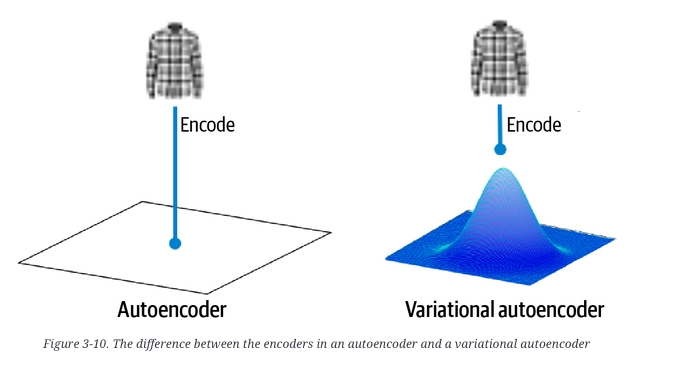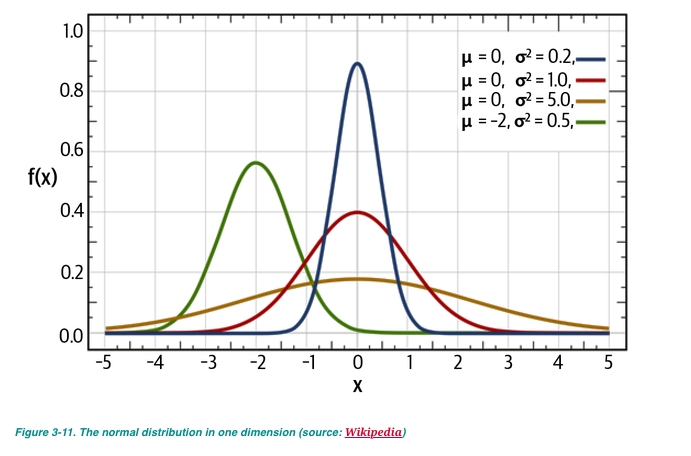So far we have been using a standard encode/decode model to place points in a latent space for specific items of clothing in the Fashion-MNIST dataset. This worked pretty well, except when we started to get slightly outside of the clusters formed by the encodings when we created new items they became a bit muddled. We can help solve this by using some statistics to ensure that the space around our encodings decodes to similar items. To do this, instead of encoding to a single point in the latent space, we are going to encode to a normal distribution around that point.

<img src="./images/encoding distribution.jpeg" alt="encoding distribution" width=500>



Normal distributions look like bells when graphed out and are defined by the mean (usually represented as mu ($\mu$)) and the variance (usually represented as simga squared ($\sigma^2$)). The standard deviation is just the square root of the variance ($\sigma$). 

<img src="./images/normal distributions.jpeg" alt="normal distributions" width=500>

What does this mean for us? This means we need to do a little additional coding to the encoder to get it to map to the latent space using a couple of different vectors, a mean vector and a variance vector. 

Variances are always positive so we take the log of the variance, and with that we will have:

***z_mean*** - the mean point of the distribution
***z_log_var*** - the logarithm of the variance of each dimension

We take a sample from the distribution using the equation $z = z\_mean + z\_sigma \ast epsilon$ where:
$$
z\_sigma = exp(z\_log_var \ast 0.5)\newline
epsilon \sim N(0, I)
$$

### Let's Code!

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from utils import display

2024-10-04 09:37:35.811383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 09:37:39.726685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 20
EPOCHS = 10
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [3]:
## Load the data downloaded from Tensorflow

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

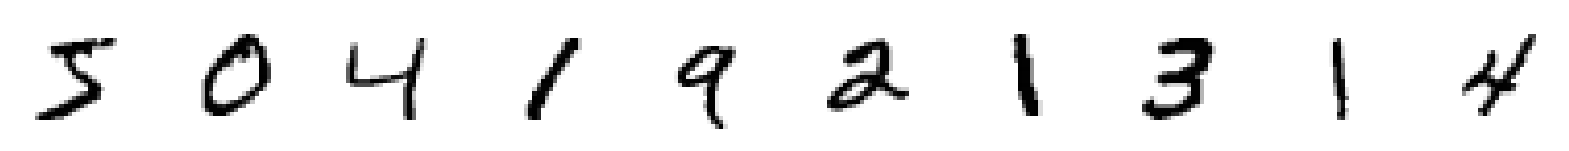

In [5]:

display(x_train)

## 2. Build the variational autoencoder <a name="build"></a>

First we are going to build a new class that we will use to sample from the distribution that we set.

We can create a new layer in or model by subclassing the Keras `Layer` class. This allows us to do transformations to layers that aren't already defined in the API.

In [6]:
# Sampling class
class Sampling(layers.Layer):
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Now we build a modified encoder utilizing the `Sampling` class we created.

In [7]:
# Encoder

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)

z_mean = layers.Dense(EMBEDDING_DIM, name='z_mean')(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

2024-10-04 09:37:47.939730: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 09:37:49.120019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 09:37:49.140016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │     40,980 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 20)        │     40,980 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 20)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,632 (682.16 KB)

 Trainable params: 174,632 (682.16 KB)

 Non-trainable params: 0 (0.00 B)

Some changes we made:

- We connected the `Flatten` layer to $z\_mean$ and $z\_log\_var$ instead of directly to the latent space
- The `Sampling` layer uses the normal distribution defined by $z\_mean$ and $z\_log\_var$ to sample a point in the latent space
- We adjusted the Keras `Model` to take in an image input and output a point sampled from the normal distribution


The decoder is going to be the same as the decoder we used in the autoencoder.

In [8]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,137 (1.08 MB)

 Trainable params: 283,137 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Using distributions complicates calculating loss. Instead of just determining the loss between two points, we now have to calculate loss between to normal distributions. For this we are going to use the ***Kullback-Liebler (KL) divergence*** term.

This has a couple of advantages. First we get a standard normal distribution to use and second it forces all encoded distributions toward that standard normal distribution so there are fewer large gaps between point clusters.

In [9]:
# The Variational Autoencoder

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]
    
    def call(self, inputs):
        ''' Call the model on a particular input '''
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        ''' Step run during training '''
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, 
                                                                                   axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - 
                                                          tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss
    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        ''' Step run during validation '''
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, 
                                                                                   axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - 
                                                          tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss
        
        return {'loss': total_loss, 'reconstruction_loss': reconstruction_loss,
                'kl_loss': kl_loss}
        
        

In [10]:
# Create a variational autoencoder

vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [11]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [13]:
with tf.device('/GPU:0'):
    vae.fit(
        x_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[model_checkpoint_callback, tensorboard_callback],
    )

2024-10-04 09:37:52.461239: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.
2024-10-04 09:37:53.528322: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1728052677.589501   21151 service.cc:145] XLA service 0x785f8c0137a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728052677.589620   21151 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-04 09:37:57.711856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 09:37:58.955226: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1728052688.239504   21151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


594/600 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 5.1458 - reconstruction_loss: 128.9743 - total_loss: 134.1201

2024-10-04 09:38:13.334429: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-10-04 09:38:13.543419: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2024-10-04 09:38:13.641189: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - kl_loss: 5.1724 - reconstruction_loss: 128.5090 - total_loss: 133.6814 - val_kl_loss: 13.4902 - val_loss: 69.3096 - val_reconstruction_loss: 55.8194
Epoch 2/10
 14/600 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 12.8814 - reconstruction_loss: 55.3501 - total_loss: 68.2316

/home/dsu/genai/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 13.7276 - reconstruction_loss: 52.4248 - total_loss: 66.1525 - val_kl_loss: 14.7510 - val_loss: 63.7310 - val_reconstruction_loss: 48.9800
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 15.3539 - reconstruction_loss: 47.0184 - total_loss: 62.3722 - val_kl_loss: 14.9795 - val_loss: 62.3406 - val_reconstruction_loss: 47.3611
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 15.6621 - reconstruction_loss: 45.3384 - total_loss: 61.0005 - val_kl_loss: 15.5069 - val_loss: 61.3266 - val_reconstruction_loss: 45.8197
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - kl_loss: 15.8629 - reconstruction_loss: 44.2599 - total_loss: 60.1228 - val_kl_loss: 15.6803 - val_loss: 61.2922 - val_reconstruction_loss: 45.6118
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 15.9992 - reconstruction_loss: 43.7368 - total_loss: 59.7361 - val_kl_loss: 16.0082 - val_loss: 61.2330 - val_reconstruction_loss: 45.2248
E

In [14]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder_vae.keras")
decoder.save("./models/decoder_vae.keras")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [15]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Example real clothing items


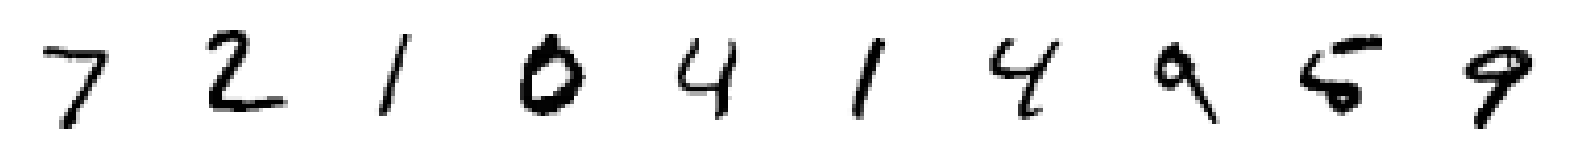

Reconstructions


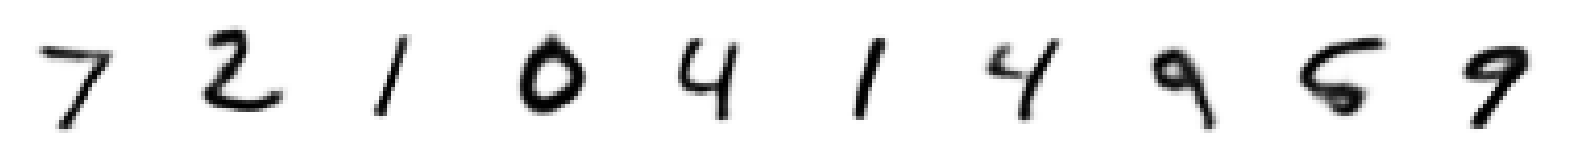

In [16]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder <a name="encode"></a>

In [17]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [18]:
# Some examples of the embeddings
print(z[:10])

[[ 6.52533472e-01 -3.57518524e-01  2.10741949e+00 -1.84551120e+00
  -2.13311672e-01 -5.22431672e-01 -1.20266214e-01  1.63705528e-01
   5.87149680e-01 -3.01622510e-01  8.61373991e-02 -1.00184262e+00
   1.51044595e+00  6.66826069e-02 -4.42150235e-02  2.53413200e-01
   8.12064350e-01 -9.94364083e-01  1.36445975e+00  1.39319694e+00]
 [-1.37579894e+00  1.57999134e+00 -1.05329180e+00  3.57758760e-01
   1.60136175e+00  7.43779391e-02 -1.29253566e-01 -2.86321696e-02
  -7.41701424e-02 -2.37644196e-01 -1.52286977e-01  2.28729177e+00
   7.71858543e-02  1.29882240e+00  9.93600488e-01  1.24869108e+00
   2.39836499e-01 -6.03148699e-01  3.23096693e-01 -2.46636605e+00]
 [-2.78232813e-01  1.65888995e-01  8.51411581e-01  9.09296274e-01
   1.15255249e+00 -5.31868041e-01  3.27691853e-01 -2.37819147e+00
  -1.43568158e-01  5.83704233e-01 -1.21837521e+00 -7.87742019e-01
  -1.49802431e-01  2.37858593e-02  2.69567966e-01 -1.31403363e+00
  -1.23981261e+00 -4.16191757e-01 -9.43705559e-01 -1.10015899e-01]
 [ 1.50

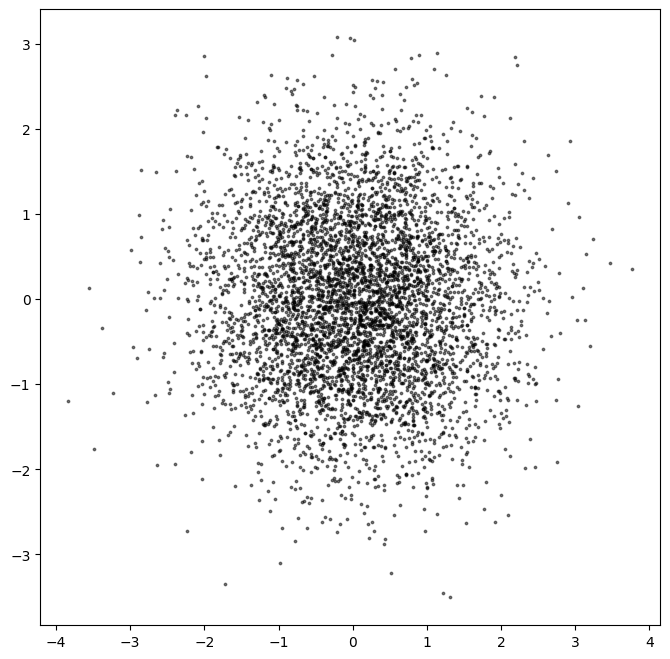

In [19]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [20]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [21]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 20), found shape=(18, 2)

In [22]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

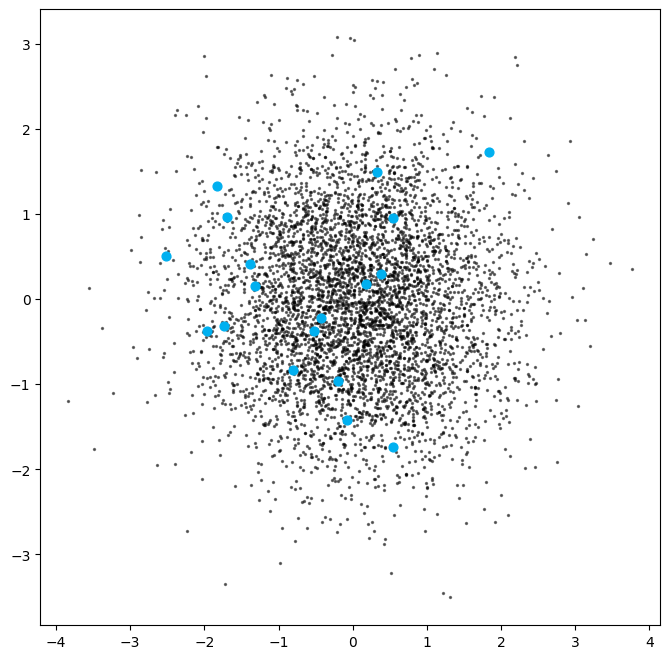

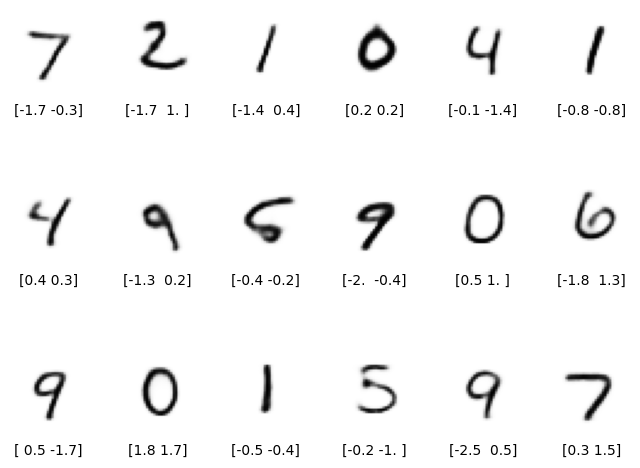

In [23]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

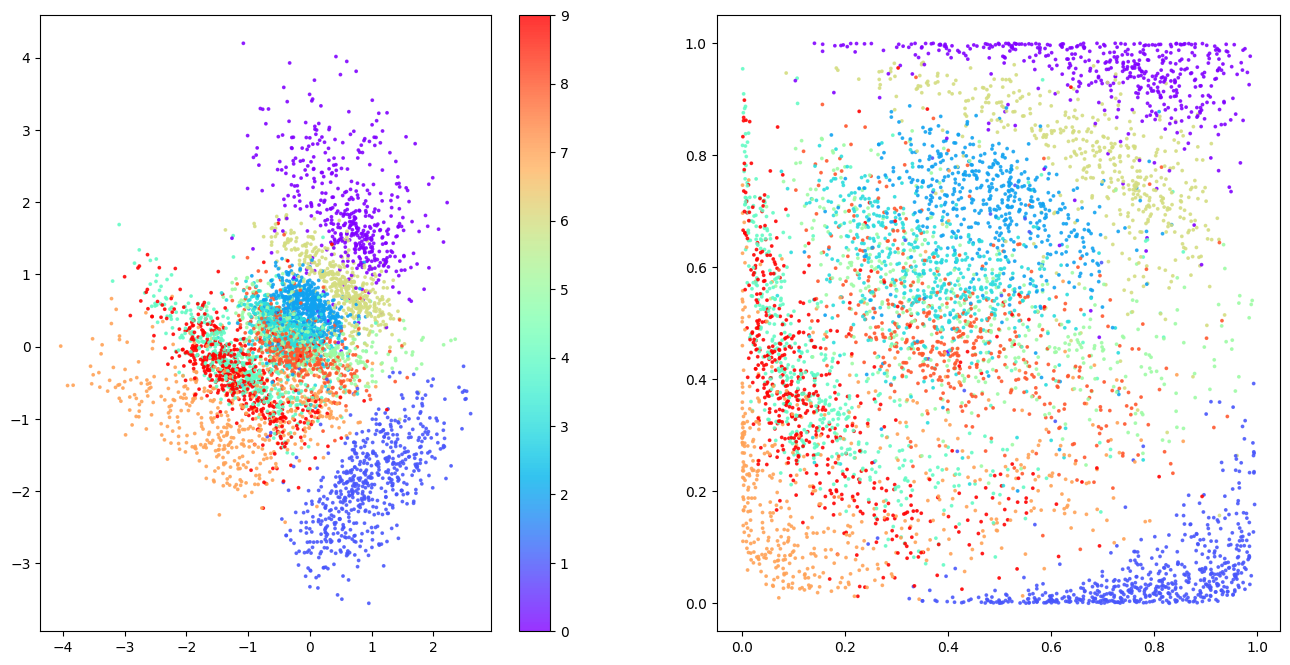

In [24]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


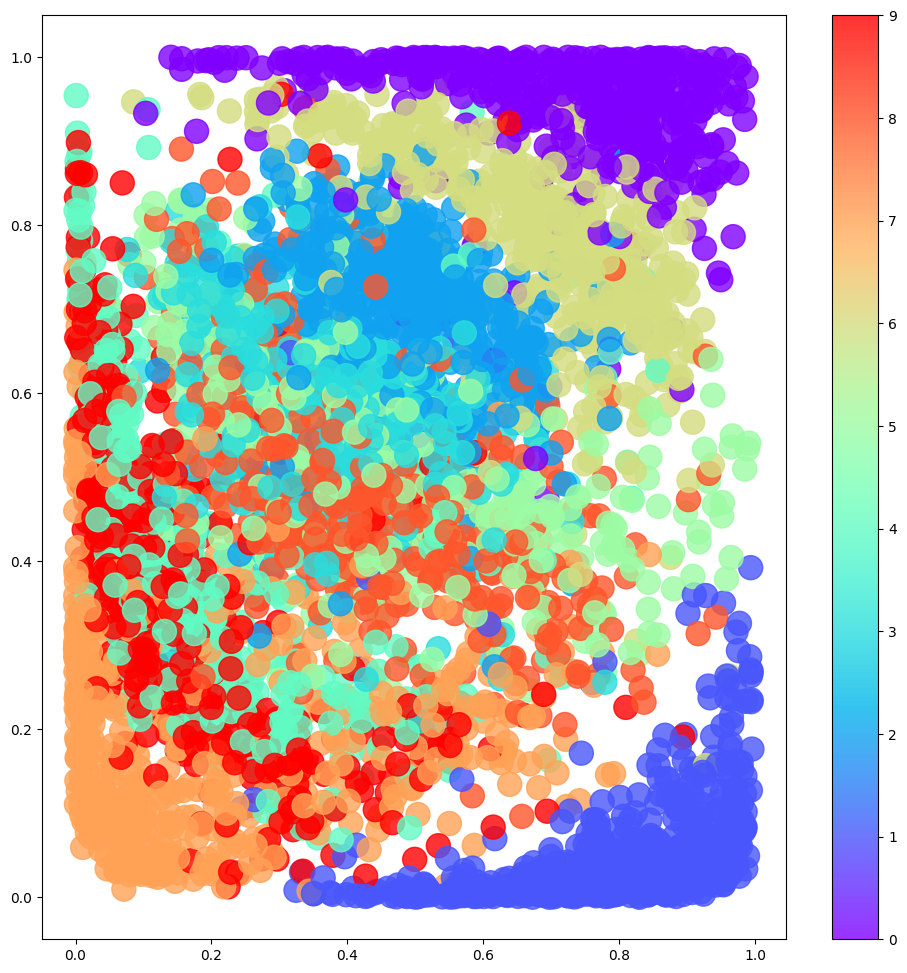

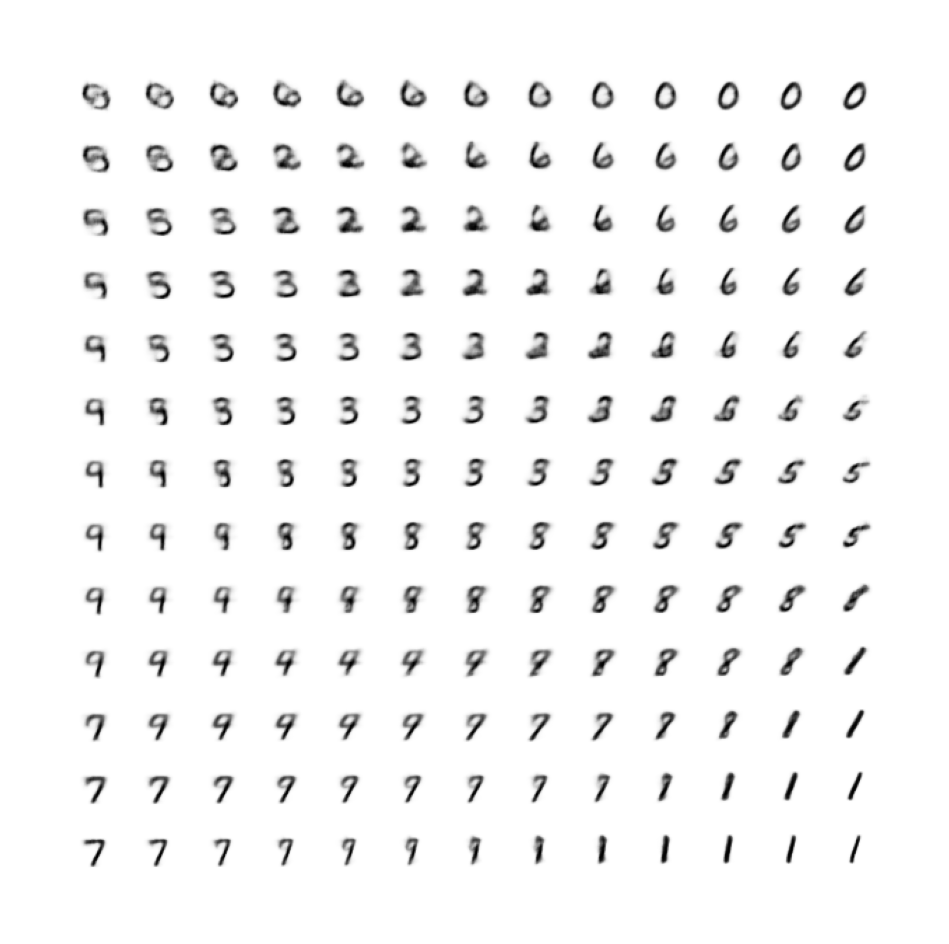

In [25]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")